In [82]:
!pip freeze > requirements.txt

In [1]:
import sklearn
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from functools import reduce
!git clone https://github.com/koreal6803/Stocker.git
!pip install -r Stocker/requirements.txt

Cloning into 'Stocker'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13
Unpacking objects: 100% (13/13), done.
  Created wheel for pytrends: filename=pytrends-4.8.0-py3-none-any.whl size=16126 sha256=c95b9e951a039043e17155a871c79a8008bd8a70e147316916da180857e9a37c
  Stored in directory: /root/.cache/pip/wheels/07/6f/5c/8174f98dec1bfbc7d5da4092854afcbcff4b26c3d9b66b5183
Successfully built pytrends


In [2]:
# Load your cloud drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 讀入series
colnames=['Open','High','Low','Close'] 
df_temp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/training.csv', names=colnames)
date = pd.date_range(start='2015/01/01',periods=len(df_temp))
df = df_temp
date = pd.DataFrame(date)
df[['Date']] = date
#df.set_index('Date',inplace=True)
price = df.squeeze()
price.head()

,Open,High,Low,Close,Date
0,186.73,188.71,186.00,186.30,2015-01-01
1,185.57,186.33,184.94,185.54,2015-01-02
2,184.81,185.03,183.10,184.66,2015-01-03
3,184.39,184.48,182.31,182.54,2015-01-04
4,182.20,182.27,180.27,181.59,2015-01-05


In [4]:
# 讀入series
colnames=['Open','High','Low','Close'] 
df_temp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/testing.csv', names=colnames)
date2 = pd.date_range(start=date.iloc[len(date)-1,0],periods=2)
date2 = pd.DataFrame(date2)
date2 = pd.date_range(start=date2.iloc[len(date2)-1,0],periods=len(df_temp))
date2 = pd.DataFrame(date2)
df2 = df_temp
df2[['Date']] = date2
#df2.set_index('Date',inplace=True)
price2 = df2.squeeze()
price2.head()

,Open,High,Low,Close,Date
0,154.40,155.02,152.91,154.76,2019-01-28
1,155.96,156.80,155.07,156.46,2019-01-29
2,156.45,156.74,154.68,155.35,2019-01-30
3,154.10,156.22,154.09,154.10,2019-01-31
4,153.59,154.45,153.26,153.57,2019-02-01


In [ ]:
# df = df[['Date', 'Open']]
# df2 = df2[['Date', 'Open']]
# df.columns = ['ds', 'y']
# df2.columns = ['ds', 'y']
# print(df)

In [5]:
df = pd.concat([df,df2])
df = df.reset_index()
df = df[['Open','High','Low','Close','Date']]
df

,Open,High,Low,Close,Date
0,186.73,188.71,186.00,186.30,2015-01-01
1,185.57,186.33,184.94,185.54,2015-01-02
2,184.81,185.03,183.10,184.66,2015-01-03
3,184.39,184.48,182.31,182.54,2015-01-04
4,182.20,182.27,180.27,181.59,2015-01-05
...,...,...,...,...,...
1503,151.82,153.00,151.50,152.50,2019-02-12
1504,152.51,153.86,152.50,152.83,2019-02-13
1505,152.95,153.18,152.61,153.13,2019-02-14
1506,153.20,154.12,153.20,154.04,2019-02-15


In [6]:
def relative_strength_idx(df, n=14):
    Open = df['Open']
    delta = Open.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

# SMA
df['EMA_3'] = df['Open'].ewm(3).mean().shift()
df['EMA_7'] = df['Open'].ewm(7).mean().shift()
df['EMA_30'] = df['Open'].ewm(30).mean().shift()

# EMA
df['SMA_3'] = df['Open'].rolling(3).mean().shift()
df['SMA_7'] = df['Open'].rolling(7).mean().shift()
df['SMA_30'] = df['Open'].rolling(30).mean().shift()

# RSI
df['RSI'] = relative_strength_idx(df).fillna(0)

# MACD
EMA_12 = pd.Series(df['Open'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Open'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

In [7]:
df

,Open,High,Low,Close,Date,EMA_3,EMA_7,EMA_30,SMA_3,SMA_7,SMA_30,RSI,MACD,MACD_signal
0,186.73,188.71,186.00,186.30,2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,185.57,186.33,184.94,185.54,2015-01-02,186.730000,186.730000,186.730000,NaN,NaN,NaN,0.000000,NaN,NaN
2,184.81,185.03,183.10,184.66,2015-01-03,186.067143,186.111333,186.140492,NaN,NaN,NaN,0.000000,NaN,NaN
3,184.39,184.48,182.31,182.54,2015-01-04,185.523514,185.618521,185.682375,185.703333,NaN,NaN,0.000000,NaN,NaN
4,182.20,182.27,180.27,181.59,2015-01-05,185.108971,185.247428,185.343221,184.923333,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,151.82,153.00,151.50,152.50,2019-02-12,153.959155,154.003686,152.058031,153.623333,154.181429,152.667333,33.225284,0.302666,0.702389
1504,152.51,153.86,152.50,152.83,2019-02-13,153.424367,153.730726,152.050352,152.880000,153.498571,152.730333,34.290271,0.183406,0.598592
1505,152.95,153.18,152.61,153.13,2019-02-14,153.195775,153.578135,152.065180,152.500000,153.200000,152.792333,44.590781,0.122978,0.503469
1506,153.20,154.12,153.20,154.04,2019-02-15,153.134331,153.499618,152.093722,152.426667,153.105714,152.928000,48.119576,0.094176,0.421611


In [8]:
df['y'] = df['Open'].shift(-1)
print(df)
df = df.dropna(axis=0).reset_index(drop=True)

        Open    High     Low   Close       Date       EMA_3       EMA_7  \
0     186.73  188.71  186.00  186.30 2015-01-01         NaN         NaN   
1     185.57  186.33  184.94  185.54 2015-01-02  186.730000  186.730000   
2     184.81  185.03  183.10  184.66 2015-01-03  186.067143  186.111333   
3     184.39  184.48  182.31  182.54 2015-01-04  185.523514  185.618521   
4     182.20  182.27  180.27  181.59 2015-01-05  185.108971  185.247428   
...      ...     ...     ...     ...        ...         ...         ...   
1503  151.82  153.00  151.50  152.50 2019-02-12  153.959155  154.003686   
1504  152.51  153.86  152.50  152.83 2019-02-13  153.424367  153.730726   
1505  152.95  153.18  152.61  153.13 2019-02-14  153.195775  153.578135   
1506  153.20  154.12  153.20  154.04 2019-02-15  153.134331  153.499618   
1507  154.17  154.72  153.42  153.42 2019-02-16  153.150748  153.462166   

          EMA_30       SMA_3       SMA_7      SMA_30        RSI      MACD  \
0            NaN      

In [9]:
df_train = df.head(len(df)-len(df2)+1)
df_valid = df.tail(len(df2)-1)

# 畫圖看一下
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train.Date, y=df_train.Open, name='Training'))
fig.add_trace(go.Scatter(x=df_valid.Date, y=df_valid.Open, name='Validation'))
fig.show()

In [11]:
df_train

,Open,High,Low,Close,Date,EMA_3,EMA_7,EMA_30,SMA_3,SMA_7,SMA_30,RSI,MACD,MACD_signal,y
0,193.73,194.24,192.46,193.39,2015-02-03,192.719549,191.885754,189.496661,192.876667,192.641429,188.561667,53.892944,1.404344,1.492153,193.03
1,193.03,194.74,192.75,193.87,2015-02-04,192.972176,192.118772,189.699863,193.350000,192.741429,188.873000,48.977273,1.335050,1.456953,193.87
2,193.87,199.23,193.28,197.61,2015-02-05,192.986632,192.233749,189.857234,193.490000,192.922857,189.234000,56.284153,1.328643,1.428880,198.38
3,198.38,198.56,196.61,197.76,2015-02-06,193.207481,192.439966,190.044061,193.543333,193.002857,189.588667,70.260223,1.648993,1.476151,196.78
4,196.78,198.71,196.10,197.53,2015-02-07,194.500642,193.187817,190.426696,195.093333,193.948571,190.177000,64.726027,1.759369,1.536089,197.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,151.95,152.20,151.33,151.84,2019-01-23,150.506551,150.775860,150.032494,151.313333,149.565714,152.479667,43.880100,-0.136623,-0.106433,152.06
1451,152.06,152.49,151.62,151.98,2019-01-24,150.867414,150.922628,150.094349,151.750000,150.137143,152.626000,51.384909,-0.028277,-0.090802,152.35
1452,152.35,152.93,151.70,152.47,2019-01-25,151.165560,151.064799,150.157757,152.003333,150.717143,152.778667,54.729730,0.080066,-0.056628,152.81
1453,152.81,153.61,152.17,153.55,2019-01-26,151.461670,151.225449,150.228474,152.120000,151.377143,152.949667,55.712937,0.200733,-0.005156,153.65


In [10]:
df_valid

,Open,High,Low,Close,Date,EMA_3,EMA_7,EMA_30,SMA_3,SMA_7,SMA_30,RSI,MACD,MACD_signal,y
1455,154.40,155.02,152.91,154.76,2019-01-28,152.261564,151.701828,150.419435,152.936667,152.302857,153.040000,69.152196,0.540497,0.162398,155.96
1456,155.96,156.80,155.07,156.46,2019-01-29,152.796173,152.039100,150.547840,153.620000,152.745714,152.860000,86.951983,0.800202,0.289959,156.45
1457,156.45,156.74,154.68,155.35,2019-01-30,153.587130,152.529212,150.722426,154.670000,153.311429,152.689667,96.498906,1.033644,0.438696,154.10
1458,154.10,156.22,154.09,154.10,2019-01-31,154.302847,153.019311,150.907187,155.603333,153.954286,152.503000,76.660839,1.017296,0.554416,153.59
1459,153.59,154.45,153.26,153.57,2019-02-01,154.252136,153.154397,151.010181,155.503333,154.245714,152.318000,75.085616,0.952211,0.633975,154.81
1460,154.81,155.03,153.55,154.81,2019-02-02,154.086602,153.208847,151.093401,154.713333,154.422857,152.237333,74.224978,0.987689,0.704718,155.46
1461,155.46,155.89,154.57,155.41,2019-02-03,154.267451,153.408991,151.213291,154.166667,154.708571,152.254000,72.650376,1.056081,0.774990,156.74
1462,156.74,157.85,155.16,156.74,2019-02-04,154.565588,153.665368,151.350281,154.620000,154.967143,152.284667,74.156306,1.199738,0.859940,156.60
1463,156.60,156.73,153.89,153.91,2019-02-05,155.109191,154.049697,151.524143,155.670000,155.301429,152.384000,71.495327,1.287449,0.945442,154.60
1464,154.60,155.11,153.70,154.00,2019-02-06,155.481894,154.368485,151.687881,156.266667,155.392857,152.459667,60.474308,1.181953,0.992744,153.61


In [12]:
from fbprophet import Prophet

features = ['SMA_3','SMA_7','SMA_30','EMA_3','EMA_7','EMA_30','RSI','MACD','MACD_signal']
model_fbp = Prophet()
for feature in features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[['Date', 'Open'] + features].rename(columns={'Date': 'ds', 'Open': 'y'}))
forecast = model_fbp.predict(df_valid[['Date', 'Open'] + features].rename(columns={'Date': 'ds'}))
df_valid["Forecast_Prophet"] = forecast.yhat.values
df_valid['Forecast_Prophet']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1455    154.400158
1456    155.926744
1457    156.385020
1458    154.074867
1459    153.616396
1460    154.859119
1461    155.459209
1462    156.713498
1463    156.548931
1464    154.587447
1465    153.678120
1466    153.631425
1467    154.011176
1468    153.562038
1469    153.074938
1470    151.773708
1471    152.511506
1472    152.870816
1473    153.050903
Name: Forecast_Prophet, dtype: float64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



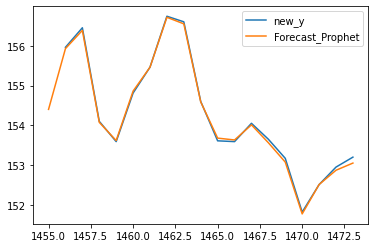

In [13]:
df_valid['new_y'] = df_valid['y'].shift(1)
df_valid[['new_y', 'Forecast_Prophet']].plot()

In [ ]:
df2

In [14]:
df_valid[['Date','y','Forecast_Prophet']]

,Date,y,Forecast_Prophet
1455,2019-01-28,155.96,154.400158
1456,2019-01-29,156.45,155.926744
1457,2019-01-30,154.10,156.385020
1458,2019-01-31,153.59,154.074867
1459,2019-02-01,154.81,153.616396
1460,2019-02-02,155.46,154.859119
1461,2019-02-03,156.74,155.459209
1462,2019-02-04,156.60,156.713498
1463,2019-02-05,154.60,156.548931
1464,2019-02-06,153.61,154.587447


In [15]:
df_valid['Forecast_Prophet'].head()

1455    154.400158
1456    155.926744
1457    156.385020
1458    154.074867
1459    153.616396
Name: Forecast_Prophet, dtype: float64

In [67]:
predict_price = df_valid['Forecast_Prophet'].tolist()
predict_price.insert(0,df_train['Open'][len(df_train)-1])
predict_price

[153.65,
 154.40015783842617,
 155.92674373161626,
 156.38502028583798,
 154.07486674769353,
 153.6163963264394,
 154.85911923873033,
 155.45920882119938,
 156.713497651203,
 156.54893143790596,
 154.58744687416413,
 153.67812001103965,
 153.6314250078025,
 154.01117642391904,
 153.56203765641973,
 153.07493817385875,
 151.77370849935932,
 152.5115059885417,
 152.87081625627812,
 153.0509026272751]

In [69]:
own = 0
answer = []
for i in range(len(predict_price)-2):
  #print(predict_price[i])
  if predict_price[i+1] > predict_price[i+2]:
    if own == 0:
      own -= 1
      answer.append(-1)
    elif own == 1:
      own -= 1
      answer.append(-1)
    elif own == -1:
      answer.append(0)
  elif predict_price[i+1] < predict_price[i+2]:
    if own == 0:
      own += 1
      answer.append(1)
    elif own == 1:
      answer.append(0)
    elif own == -1:
      own += 1
      answer.append(1)
  elif predict_price[i+1] == predict_price[i+2]:
    answer.append(0)
  #print(own)
if own == 1:
  own -= 1
  answer.append(-1)
elif own == -1:
  own += 1
  answer.append(1)
answer

[1, 0, -1, -1, 1, 1, 0, -1, -1, 0, 0, 1, -1, 0, 0, 1, 1, 0, -1]

In [70]:
csv_file = open("/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/output.csv", "w")
for i in answer:
  csv_file.write(str(i)+'\n')
csv_file.close()

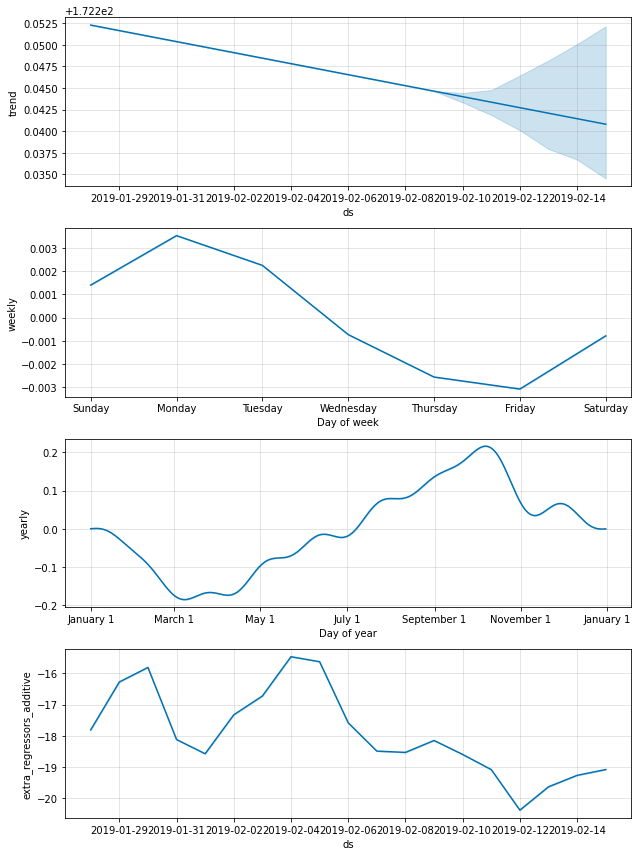

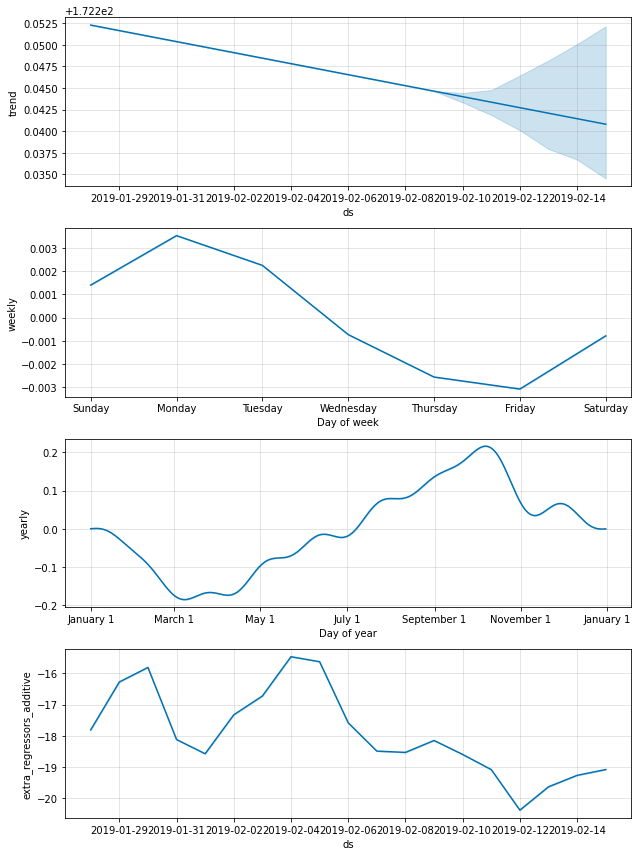

In [64]:
model_fbp.plot_components(forecast)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df_valid.Date, y=df_valid.y, name='Close'))
# fig.add_trace(go.Scatter(x=df_valid.Date, y=df_valid.Forecast_ARIMAX, name='Forecast_ARIMAX'))
# fig.add_trace(go.Scatter(x=df_valid.Date, y=df_valid.Forecast_Prophet, name='Forecast_Prophet'))
# fig.show()

#print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.y, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.y, df_valid.Forecast_Prophet)))
#print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.y, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.y, df_valid.Forecast_Prophet))

In [60]:
from pandas.core.frame import DataFrame
# You can write code above the if-main block.

import argparse
if __name__ == '__main__':
    # You should not modify this part.
    


    parser = argparse.ArgumentParser()
    parser.add_argument('--training',default='/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/training_data.csv',help='input training data file name')
    parser.add_argument('--testing',default='/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/testing_data.csv',help='input testing data file name')
    parser.add_argument('--output',default='/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/output.csv',help='output file name')   
    args = parser.parse_args(args=[])


/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/testing_data.csv
/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/output.csv


In [73]:
# Load your cloud drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[1, -1, -1, 1, 1, 0, -1, -1, 0, 0, 1, -1, 0, 0, 1, 1, 0, -1, 0]
RMSE of Prophet: 1.0385524955587517
MAE of Prophet: 0.8476868908617639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



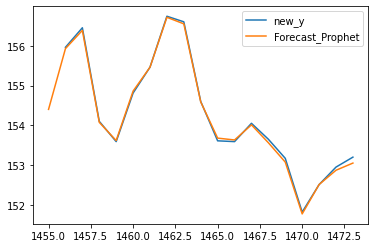

In [77]:
# -*- coding: utf-8 -*-

import sklearn
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.metrics import mean_absolute_error, mean_squared_error
from fbprophet import Prophet
import plotly.graph_objects as go
import argparse


# Load your cloud drive
from google.colab import drive
drive.mount('/content/drive')

def run(train,test,output):
      
  # 讀入series
  colnames=['Open','High','Low','Close'] 
  df_temp = pd.read_csv(train, names=colnames)
  date = pd.date_range(start='2015/01/01',periods=len(df_temp))
  df = df_temp
  date = pd.DataFrame(date)
  df[['Date']] = date
  #df.set_index('Date',inplace=True)
  price = df.squeeze()
  price.head()

  # 讀入series
  colnames=['Open','High','Low','Close'] 
  df_temp = pd.read_csv(test, names=colnames)
  date2 = pd.date_range(start=date.iloc[len(date)-1,0],periods=2)
  date2 = pd.DataFrame(date2)
  date2 = pd.date_range(start=date2.iloc[len(date2)-1,0],periods=len(df_temp))
  date2 = pd.DataFrame(date2)
  df2 = df_temp
  df2[['Date']] = date2
  #df2.set_index('Date',inplace=True)
  price2 = df2.squeeze()
  price2.head()

  # df = df[['Date', 'Open']]
  # df2 = df2[['Date', 'Open']]
  # df.columns = ['ds', 'y']
  # df2.columns = ['ds', 'y']
  # print(df)

  df = pd.concat([df,df2])
  df = df.reset_index()
  df = df[['Open','High','Low','Close','Date']]

  def relative_strength_idx(df, n=14):
      Open = df['Open']
      delta = Open.diff()
      delta = delta[1:]
      pricesUp = delta.copy()
      pricesDown = delta.copy()
      pricesUp[pricesUp < 0] = 0
      pricesDown[pricesDown > 0] = 0
      rollUp = pricesUp.rolling(n).mean()
      rollDown = pricesDown.abs().rolling(n).mean()
      rs = rollUp / rollDown
      rsi = 100.0 - (100.0 / (1.0 + rs))
      return rsi

  # SMA
  df['EMA_3'] = df['Open'].ewm(3).mean().shift()
  df['EMA_7'] = df['Open'].ewm(7).mean().shift()
  df['EMA_30'] = df['Open'].ewm(30).mean().shift()

  # EMA
  df['SMA_3'] = df['Open'].rolling(3).mean().shift()
  df['SMA_7'] = df['Open'].rolling(7).mean().shift()
  df['SMA_30'] = df['Open'].rolling(30).mean().shift()

  # RSI
  df['RSI'] = relative_strength_idx(df).fillna(0)

  # MACD
  EMA_12 = pd.Series(df['Open'].ewm(span=12, min_periods=12).mean())
  EMA_26 = pd.Series(df['Open'].ewm(span=26, min_periods=26).mean())
  df['MACD'] = pd.Series(EMA_12 - EMA_26)
  df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

  df['y'] = df['Open'].shift(-1)
  #print(df)
  df = df.dropna(axis=0).reset_index(drop=True)

  df_train = df.head(len(df)-len(df2)+1)
  df_valid = df.tail(len(df2)-1)

  # 畫圖看一下

  # fig = go.Figure()
  # fig.add_trace(go.Scatter(x=df_train.Date, y=df_train.Open, name='Training'))
  # fig.add_trace(go.Scatter(x=df_valid.Date, y=df_valid.Open, name='Validation'))
  # fig.show()

  features = ['SMA_3','SMA_7','SMA_30','EMA_3','EMA_7','EMA_30','RSI','MACD','MACD_signal']
  model_fbp = Prophet()
  for feature in features:
      model_fbp.add_regressor(feature)

  model_fbp.fit(df_train[['Date', 'Open'] + features].rename(columns={'Date': 'ds', 'Open': 'y'}))
  forecast = model_fbp.predict(df_valid[['Date', 'Open'] + features].rename(columns={'Date': 'ds'}))
  df_valid["Forecast_Prophet"] = forecast.yhat.values
  df_valid['Forecast_Prophet']

  df_valid['new_y'] = df_valid['y'].shift(1)
  df_valid[['new_y', 'Forecast_Prophet']].plot()

  predict_price = df_valid['Forecast_Prophet'].tolist()

  own = 0
  answer = []
  for i in range(len(predict_price)-2):
    #print(predict_price[i])
    if predict_price[i+1] > predict_price[i+2]:
      if own == 0:
        own -= 1
        answer.append(-1)
      elif own == 1:
        own -= 1
        answer.append(-1)
      elif own == -1:
        answer.append(0)
    elif predict_price[i+1] < predict_price[i+2]:
      if own == 0:
        own += 1
        answer.append(1)
      elif own == 1:
        answer.append(0)
      elif own == -1:
        own += 1
        answer.append(1)
    elif predict_price[i+1] == predict_price[i+2]:
      answer.append(0)
    #print(own)
  if own == 1:
    own -= 1
    answer.append(-1)
  elif own == -1:
    own += 1
    answer.append(1)
  answer.append(0)
  print(answer)
  csv_file = open(output, "w")
  for i in answer:
    csv_file.write(str(i)+'\n')
  csv_file.close()

  #model_fbp.plot_components(forecast)


  #print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.y, df_valid.Forecast_ARIMAX)))
  print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.y, df_valid.Forecast_Prophet)))
  #print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.y, df_valid.Forecast_ARIMAX))
  print("MAE of Prophet:", mean_absolute_error(df_valid.y, df_valid.Forecast_Prophet))

  # You can write code above the if-main block.

if __name__ == '__main__':
    # You should not modify this part.
    


    parser = argparse.ArgumentParser()
    parser.add_argument('--training',default='/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/training.csv',help='input training data file name')
    parser.add_argument('--testing',default='/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/testing.csv',help='input testing data file name')
    parser.add_argument('--output',default='/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/output.csv',help='output file name')   
    args = parser.parse_args(args=[])

    run(args.training, args.testing, args.output)

In [81]:
!pip freeze > requirements.txt